# Deep Convolutional Generative Adversarial Network (DCGAN)

### Loading Libraries

In [14]:
# Numerical Computing
import numpy as np

# Data Manipulation
import pandas as pd

# Data Visualization
import imageio
import matplotlib.pyplot as plt

# Warnings
import warnings

# Path & OS
from time import time
from pathlib import Path

# Notebook Optimizer
from tqdm import tqdm

# IPython
from IPython import display


# TensorFlow
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import (Dense, Reshape, Flatten, Dropout,
                                     BatchNormalization, LeakyReLU,
                                     Conv2D, Conv2DTranspose)

from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

In [16]:
warnings.filterwarnings('ignore')

In [18]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')

if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [20]:
dcgan_path = Path('dcgan')

img_path = dcgan_path / 'synthetic_images'

if not img_path.exists():
    img_path.mkdir(parents=True)

### Sample Image Saver

In [23]:
def generate_and_save_images(model, epoch, test_input):
    # Training set to false so that every layer runs in inference mode
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(5, 5.2))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    fig.suptitle(f'Epoch {epoch:03d}', fontsize=14)
    fig.tight_layout()
    fig.subplots_adjust(top=.93)
    fig.savefig(img_path / f'epoch_{epoch:03d}.png', dpi=300)
    plt.show()

### Loading & Preparing Data

#### Getting Training Images

In [72]:
(train_images, train_labels), (_, _) = fashion_mnist.load_data()

#### Extracting Image Dimensions

In [77]:
n_images = train_images.shape[0]

h = w = 28

### Reshaping to 4-D Input Format

In [80]:
train_images = (train_images
                .reshape(n_images, h, w, 1)
                .astype('float32'))

#### Normalizing Pixel Values

In [83]:
train_images = (train_images - 127.5) / 127.5

#### Create `tf.data.Dataset`

In [88]:
BUFFER_SIZE = n_images

BATCH_SIZE = 256

In [90]:
train_set = (tf.data.Dataset
             .from_tensor_slices(train_images)
             .shuffle(BUFFER_SIZE)
             .batch(BATCH_SIZE))

2025-05-07 09:21:07.784427: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Max
2025-05-07 09:21:07.784599: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-05-07 09:21:07.784605: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2025-05-07 09:21:07.784821: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-07 09:21:07.784837: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [92]:
train_set

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

### Creating DCGAN Architecture

#### Building Generator

In [95]:
def build_generator():
    return Sequential([Dense(7 * 7 * 256, 
                             use_bias=False,
                             input_shape=(100,), 
                             name='IN'),
                       BatchNormalization(name='BN1'),
                       LeakyReLU(name='RELU1'),
                       Reshape((7, 7, 256), name='SHAPE1'),
                       Conv2DTranspose(128, (5, 5), 
                                       strides=(1, 1),
                                       padding='same', 
                                       use_bias=False,
                                       name='CONV1'),
                       BatchNormalization(name='BN2'),
                       LeakyReLU(name='RELU2'),
                       Conv2DTranspose(64, (5, 5), 
                                       strides=(2, 2),
                                       padding='same', use_bias=False,
                                       name='CONV2'),
                       BatchNormalization(name='BN3'),
                       LeakyReLU(name='RELU3'),
                       Conv2DTranspose(1, (5, 5), 
                                       strides=(2, 2),
                                       padding='same', 
                                       use_bias=False,
                                       activation='tanh', 
                                       name='CONV3')],
                      name='Generator')

In [97]:
generator = build_generator()

In [99]:
generator.summary()

Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ IN (Dense)                      │ (None, 12544)          │     1,254,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN1 (BatchNormalization)        │ (None, 12544)          │        50,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ RELU1 (LeakyReLU)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ SHAPE1 (Reshape)                │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ CONV1 (Conv2DTranspose)         │ (None, 7, 7, 128)      │       819,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN2 (BatchNormalization)        │ (None, 7, 7, 128)      │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ RELU2 (LeakyReLU)               │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ CONV2 (Conv2DTranspose)         │ (None, 14, 14, 64)     │       204,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN3 (BatchNormalization)        │ (None, 14, 14, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ RELU3 (LeakyReLU)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ CONV3 (Conv2DTranspose)         │ (None, 28, 28, 1)      │         1,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

In [103]:
plot_model(generator,
           show_shapes=True,
           dpi=300,
           to_file=(dcgan_path / 'generator.png').as_posix())


You must install pydot (`pip install pydot`) for `plot_model` to work.


#### Visualizing Initial Image Quality

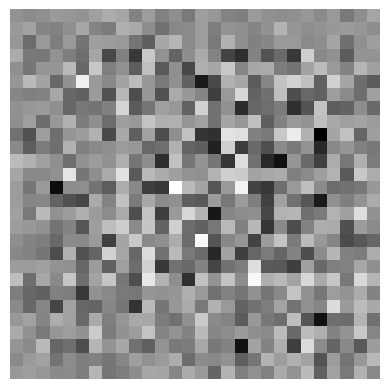

In [106]:
noise = tf.random.normal([1, 100])
generated_img = generator(noise, training=False)

plt.imshow(generated_img[0, :, :, 0], cmap='gray')
plt.axis('off');

#### Building Discriminator

In [109]:
def build_discriminator():
    return Sequential([Conv2D(64, (5, 5), 
                              strides=(2, 2), 
                              padding='same',
                              input_shape=[28, 28, 1], 
                              name='CONV1'),
                       LeakyReLU(name='RELU1'),
                       Dropout(0.3, name='DO1'),
                       Conv2D(128, (5, 5), 
                              strides=(2, 2),
                              padding='same', 
                              name='CONV2'),
                       LeakyReLU(name='RELU2'),
                       Dropout(0.3, name='DO2'),
                       Flatten(name='FLAT'),
                       Dense(1, name='OUT')],
                      name='Discriminator')

In [111]:
discriminator = build_discriminator()

In [113]:
discriminator.summary()

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ CONV1 (Conv2D)                  │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ RELU1 (LeakyReLU)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ DO1 (Dropout)                   │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ CONV2 (Conv2D)                  │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ RELU2 (LeakyReLU)               │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ DO2 (Dropout)                   │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FLAT (Flatten)                  │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ OUT (Dense)                     │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

In [115]:
plot_model(discriminator,
           show_shapes=True,
           dpi=300,
           to_file=(dcgan_path / 'discriminator.png').as_posix())

You must install pydot (`pip install pydot`) for `plot_model` to work.


#### Showing Discriminator Decision Output

In [118]:
discriminator(generated_img).numpy()

array([[-0.0007979]], dtype=float32)

### Adversarial Training

In [121]:
cross_entropy = BinaryCrossentropy(from_logits=True)

#### Generator Loss 

In [124]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

#### Discriminator Loss 

In [127]:
def discriminator_loss(true_output, fake_output):
    true_loss = cross_entropy(tf.ones_like(true_output), true_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return true_loss + fake_loss

#### Optimizers

In [130]:
gen_optimizer = Adam(1e-4)

dis_optimizer = Adam(1e-4)

#### Checkpoints

In [133]:
checkpoints_dir = dcgan_path / 'training_chpk'
checkpoint_prefix = checkpoints_dir / 'ckpt'
checkpoint = tf.train.Checkpoint(gen_optimizer=gen_optimizer,
                                 dis_optimizer=dis_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

#### Training Parameters

In [136]:
EPOCHS = 100

noise_dim = 100

In [138]:
num_ex_to_gen = 16

seed = tf.random.normal([num_ex_to_gen, noise_dim])

### Training Step

In [141]:
def train_step(images):
    # generate the random input for the generator
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        # get the generator output
        generated_img = generator(noise, training=True)
        
        # collect discriminator decisions regarding real and fake input
        true_output = discriminator(images, training=True)
        fake_output = discriminator(generated_img, training=True)
        
        # compute the loss for each model
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(true_output, fake_output)
        
    # compute the gradients for each loss with respect to the model variables
    grad_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    grad_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # apply the gradient to complete the backpropagation step
    gen_optimizer.apply_gradients(zip(grad_generator, generator.trainable_variables))
    dis_optimizer.apply_gradients(zip(grad_discriminator, discriminator.trainable_variables))

### Training Loop

In [144]:
def train(dataset, epochs, save_every=10):
    for epoch in tqdm(range(epochs)):
        start = time()

        for img_batch in dataset:
            train_step(img_batch)

        # produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every 10 EPOCHS
        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        # Generator after final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

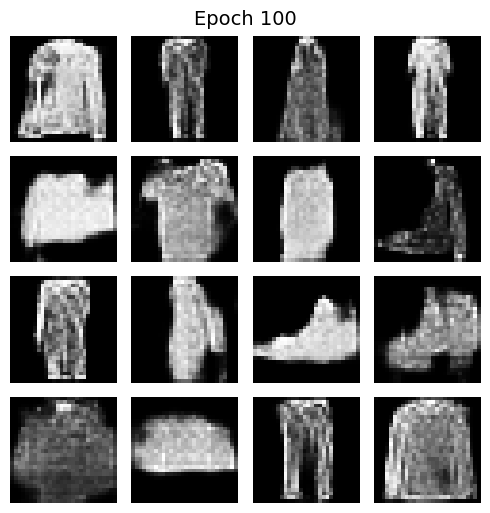

In [146]:
train(train_set, EPOCHS)

#### Restoring Last Checkpoint

In [150]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoints_dir));

### Generating Animated GIF

In [153]:
out_file = dcgan_path / 'fashion_mnist.gif'

In [155]:
with imageio.get_writer(out_file, mode='I') as writer:
    filenames = sorted(list(img_path.glob('*.png')))
    
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2 * (i ** 0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

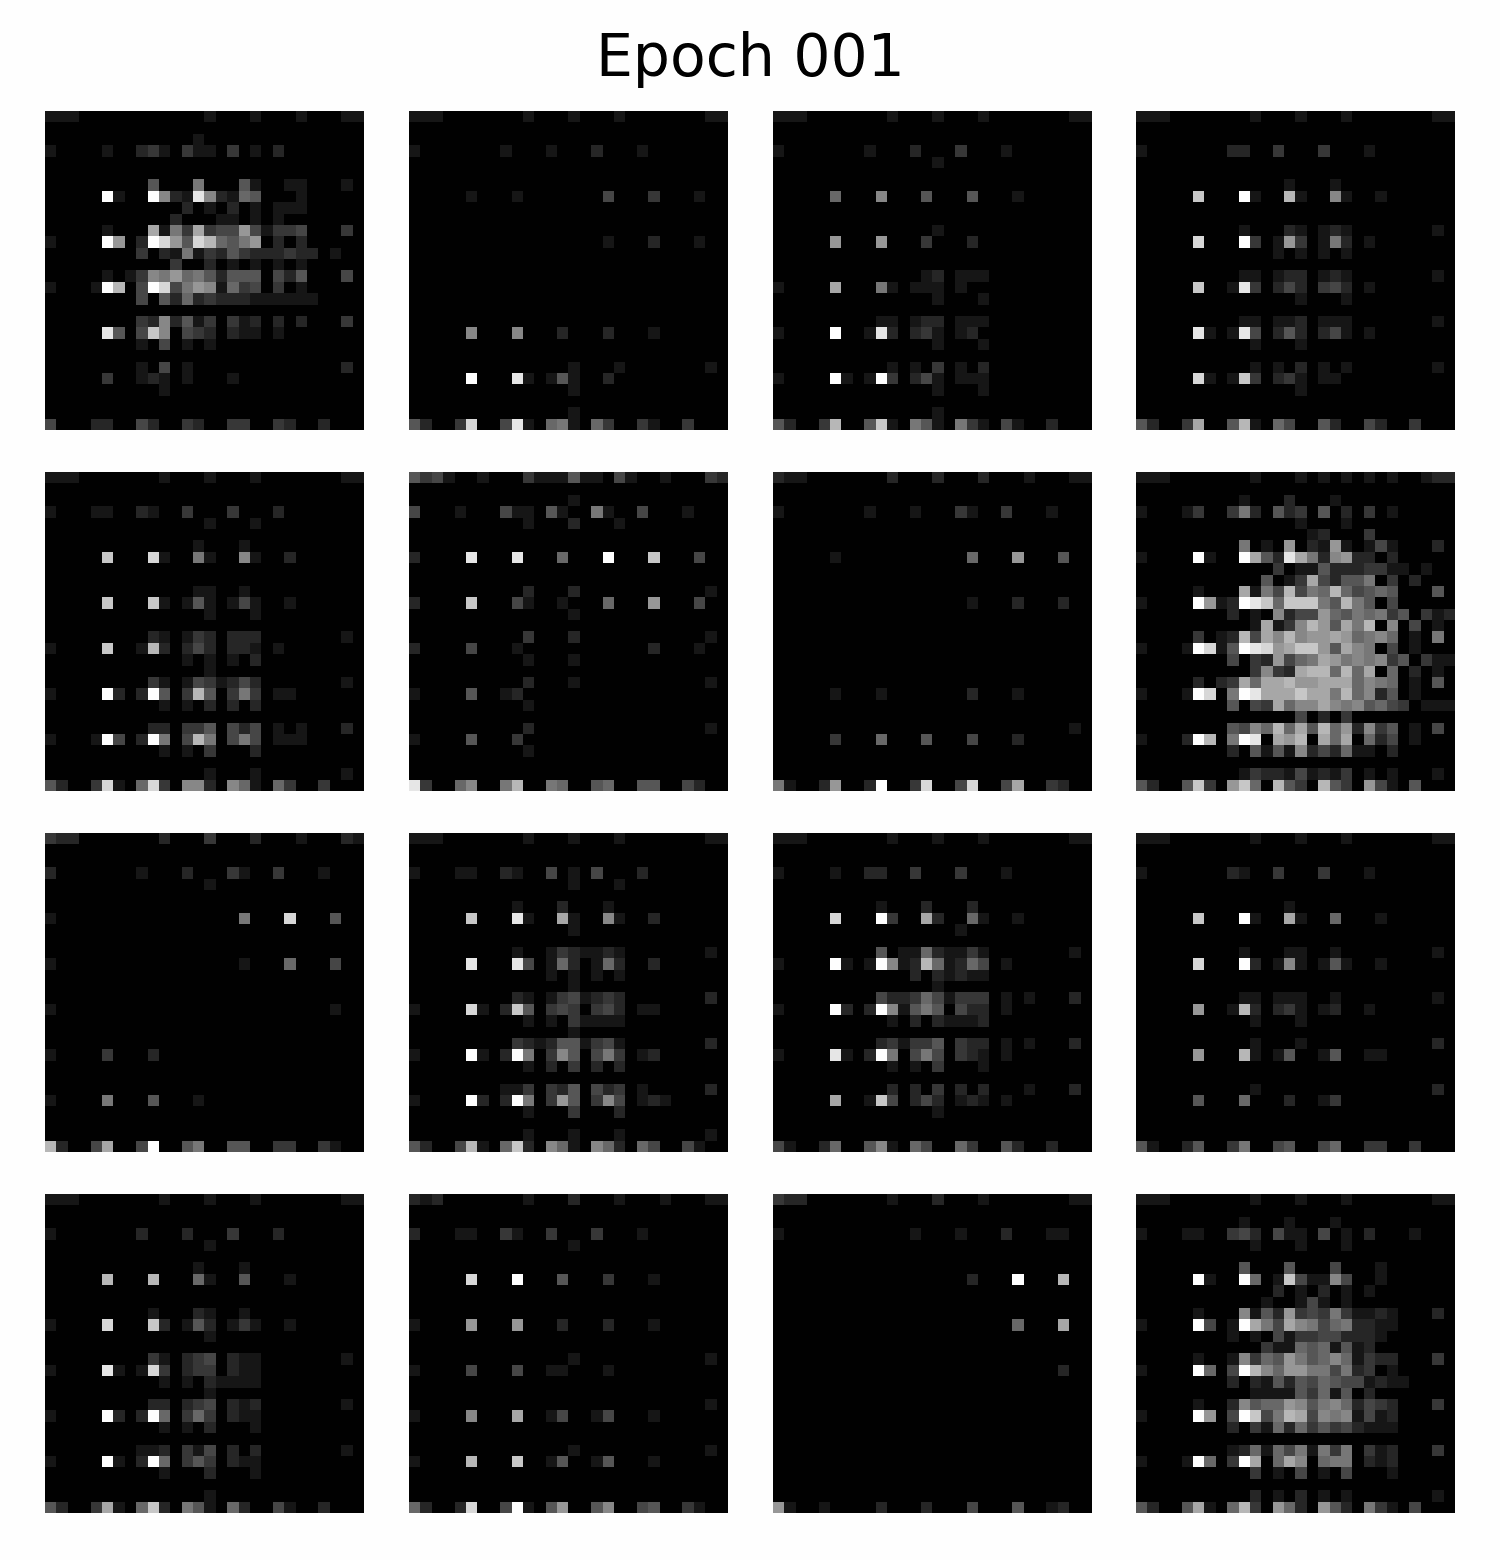

In [157]:
display.Image(filename=out_file)